## 1041 유형의 경우 연초와 연말의 물동량이 크게 달라지고, 물동량이 증가하는 구간은 1.15~6.15인 것으로 보입니다. 이러한 발견을 바탕으로 물동량이 증가하는 구간과 그 외의 구간을 나누어 prophet 알고리즘을 활용하여 예측해 보았습니다.

다만 이 때 유의미하게 예측 오차율이 낮아지지는 않았습니다.

#### 1. 모듈과 데이터를 불러오고 전처리합니다.

In [1]:
import os, sys
path_name= os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(path_name)
print(path_name)

C:\Studying\Project_Nextop\nextop-engine\nextop_engine


In [2]:
from _element import feature_control as ft_c
from _element.data_control import Data, DataRestruction, DataAddition
from _element import varr
from _element import calculations as calc
from _element.result_control import Result

from _alg.prophet import Prophet_timeseries
from _alg.arima import Arima_timeseries

from _evaluation.cross_validation import Cross_Validation
from _evaluation import compare

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import numpy as np
import pandas as pd

In [4]:
INPUT_FILENAME= 'KPP일별투입(10_17)_withallobj.xlsx'
df_raw= ft_c.xlsx_opener(path_name+varr.DF_DIR, INPUT_FILENAME)

In [5]:
data= Data()
data.setRawData(df_raw)

          ds  1025  1041  1057  1091  1111  1117  1119  1127  1163  ...    \
0 2010-01-01     0     0     0     0     0     0     0     0     0  ...     
1 2010-01-02   192  6260     0     0     0     0     0     0     0  ...     
2 2010-01-03     0     0     0     0     0     0     0     0     0  ...     
3 2010-01-04     0  5141     0   320     0     0     0     0     0  ...     
4 2010-01-05   130  5494     0  1186     0     0     0     0     0  ...     

   1754  1797  1800   1815  1817  1852  1853  1878  1891  y_sum  
0     0     0     0   2652     0     0     0     0     0   2662  
1   337     0     0  26443     0     0   459   626     0  39352  
2     0     0     0    404     0     0     0     0     0    404  
3   154   576     0  22924     0     0  3445  3305     0  44906  
4   367   294     0  39081   320     0  3861  4362   238  69481  

[5 rows x 36 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 36 columns):
ds       28

* 1041 유형만 뽑아냅니다.

In [7]:
restruct= DataRestruction(data)

In [8]:
restruct.selectSpecificY([1041])

In [9]:
df_commit= restruct.commitRestructedData()

In [10]:
data.y_col

[1041]

* 기상 데이터를 추가합니다.

In [11]:
df_temp= ft_c.xlsx_opener(path_name+varr.TEMP_DATA_DIR, 'temp_data_merged.xlsx')

In [12]:
addition= DataAddition(data)

In [13]:
addition.addXData(df_temp)
df_commit= addition.commitAddedData()

In [14]:
data.showData()

   1041         ds   temp_max   temp_min  rain_amount
0  5698 2010-07-01  30.500000  24.900000          0.0
1  2740 2010-07-02  25.799999  22.700001         70.0
2  2742 2010-07-03  25.600000  22.600000          1.0
3     0 2010-07-04  29.700001  23.100000          0.0
4  3451 2010-07-05  30.600000  21.799999          0.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2710 entries, 0 to 2709
Data columns (total 5 columns):
1041           2710 non-null int64
ds             2710 non-null datetime64[ns]
temp_max       2710 non-null float64
temp_min       2710 non-null float64
rain_amount    2710 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 127.0 KB
None


* Cross-Validation 인스턴스를 만듭니다.

In [15]:
cv= Cross_Validation(data)

In [16]:
cv.slice(1041, forecastday= varr.FORECASTDAY)

In [17]:
cv.commitRestructedData()

{frozenset({0}):       1041         ds   temp_max   temp_min  rain_amount
 0     5698 2010-07-01  30.500000  24.900000          0.0
 1     2740 2010-07-02  25.799999  22.700001         70.0
 2     2742 2010-07-03  25.600000  22.600000          1.0
 3        0 2010-07-04  29.700001  23.100000          0.0
 4     3451 2010-07-05  30.600000  21.799999          0.0
 5     6011 2010-07-06  31.000000  22.400000          0.0
 6     5312 2010-07-07  29.600000  21.900000          0.0
 7     5310 2010-07-08  29.000000  21.299999          0.0
 8     5268 2010-07-09  29.299999  21.799999          0.0
 9     5228 2010-07-10  29.100000  22.900000          0.0
 10       0 2010-07-11  25.900000  21.000000          0.0
 11    3466 2010-07-12  28.299999  22.200001          0.0
 12    4194 2010-07-13  31.299999  21.900000          0.0
 13    2585 2010-07-14  27.500000  22.700001          1.0
 14    5545 2010-07-15  29.799999  24.299999          0.0
 15    4041 2010-07-16  27.100000  21.700001         52.

* 7일 주기와 365일 주기의 segment를 만듭니다. 365일 주기는 물동량이 크게 증가하는 구간과 그렇지 않은 구간을 나누기 위함입니다.

In [18]:
restruct= DataRestruction(data)

In [19]:
restruct.addRegion(7, 'weekdayRegion', start_num= 3)
restruct.addRegion(365, 'boost1041Region', start_num= 181)

In [20]:
condition_only_sun= {
    'weekday': (0,1,2,3,4,5,),
    'sun': (6, )
}
condition_boost= {
    'boost': frozenset(range(15, 167)),
    'ordinary': frozenset(range(15))|frozenset(range(167, 365))
}
restruct.dividebyTupleCondition(
                                'weekdayRegion',
                                condition_only_sun
                                )
restruct.dividebyTupleCondition(
                                'boost1041Region',
                                condition_boost
                                )

In [21]:
restruct.deleteRegion('weekdayRegion')
restruct.deleteRegion('boost1041Region')

In [22]:
# restruct.slicebyTrainTestStructure(1041, ['ds', 'temp_max', 'temp_min', 'rain_amount'])

In [23]:
restruct.commitRestructedData()

{frozenset({0,
            'boost',
            'weekday'}):        1041         ds   temp_max   temp_min  rain_amount
 200    4923 2011-01-17  -5.000000 -12.600000          0.0
 201    3095 2011-01-18  -3.200000  -9.700000          0.0
 202    4246 2011-01-19  -3.500000 -10.400000          0.0
 203    5754 2011-01-20  -5.200000  -9.900000          0.0
 204    4858 2011-01-21  -3.500000  -8.800000          0.0
 205    4755 2011-01-22  -0.900000  -6.200000          0.0
 207    3333 2011-01-24  -6.200000 -11.600000          0.0
 208    6666 2011-01-25  -4.600000 -10.700000          0.0
 209    7011 2011-01-26  -5.300000 -11.300000          0.0
 210    7219 2011-01-27  -5.800000 -10.100000          0.0
 211    9943 2011-01-28  -4.400000 -10.400000          0.0
 212    5511 2011-01-29  -6.100000 -13.300000          0.0
 214    6126 2011-01-31  -2.200000 -10.200000          0.0
 215    5700 2011-02-01   4.800000  -2.900000          0.0
 216       0 2011-02-02   6.600000  -0.900000          

In [24]:
data.y_col

[1041]

In [25]:
data.x_col

['temp_max', 'temp_min', 'rain_amount']

* Train, Test 데이터를 만듭니다.

In [27]:
data.slicebyTrainTestStructure(1041, experiment_case= [0,1,2,3,4])

In [28]:
data.data

{frozenset({0, 'boost', 'weekday'}): {'test': Empty DataFrame
  Columns: [y, ds, temp_max, temp_min, rain_amount]
  Index: [], 'testX': Empty DataFrame
  Columns: [temp_max, temp_min, rain_amount, ds]
  Index: [], 'testY': Series([], Name: y, dtype: int64), 'train':           y         ds   temp_max   temp_min  rain_amount
  200    4923 2011-01-17  -5.000000 -12.600000          0.0
  201    3095 2011-01-18  -3.200000  -9.700000          0.0
  202    4246 2011-01-19  -3.500000 -10.400000          0.0
  203    5754 2011-01-20  -5.200000  -9.900000          0.0
  204    4858 2011-01-21  -3.500000  -8.800000          0.0
  205    4755 2011-01-22  -0.900000  -6.200000          0.0
  207    3333 2011-01-24  -6.200000 -11.600000          0.0
  208    6666 2011-01-25  -4.600000 -10.700000          0.0
  209    7011 2011-01-26  -5.300000 -11.300000          0.0
  210    7219 2011-01-27  -5.800000 -10.100000          0.0
  211    9943 2011-01-28  -4.400000 -10.400000          0.0
  212    5511 2

#### 2. prophet 라이브러리를 활용하여 예측합니다.

In [29]:
r= Result()

In [30]:
prpt_withobj= Prophet_timeseries(cv= True)

In [31]:
prpt_withobj.add_model('obj', 'day', regressor= False)

In [32]:
prpt_withobj.fit('obj', txs_traintest= data.data)

In [34]:
prpt_withobj.forecast('obj', forecast_dict= r.forecast_dict)

C:\Studying\Project_Nextop\nextop-engine\nextop_engine\_alg\prophet.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  result_forecast['ds'], box=True, format= '%Y/%m/%d', exact=True


In [41]:
r.forecast_dict

OrderedDict([('_0_merged',
              {'forecast':           ds  rain_amount  temp_max  temp_min     y         yhat
               0 2017-11-24          0.1       2.9      -2.5  8733  6649.544036
               1 2017-11-25         15.7       6.4       0.8  5100  4942.494218
               0 2017-11-26          0.0       6.4      -2.4     0     0.000000
               2 2017-11-27          0.0       8.1       1.8  4866  5116.003173
               3 2017-11-28          1.2       9.8       4.2  5723  5580.944859
               4 2017-11-29          0.0       5.7      -3.2  6732  5740.912421
               5 2017-11-30          0.0       1.8      -7.1  6909  5768.559137}),
             ('_1_merged',
              {'forecast':           ds  rain_amount   temp_max   temp_min     y         yhat
               0 2017-09-15          0.0  27.299999  17.200001  6768  6706.271357
               1 2017-09-16          0.0  26.100000  19.200001  2690  5131.227942
               0 2017-09-17      

In [40]:
r.merge_result(['0','1','2','3','4',])

In [42]:
r.err_rate()

C:\Studying\Project_Nextop\nextop-engine\nextop_engine\_element\calculations.py:13: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Studying\Project_Nextop\nextop-engine\nextop_engine\_element\calculations.py:13: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [44]:
r.avg_result()

* 예측 오차입니다.

In [45]:
r.print_err_rate()

RMSE with segment _result: 1570.1828
MAPE with segment _result: nan
MAPE_with_std with segment _result: 34.7866
MAPE_div_std with segment _result: 107.7490
sMAPE with segment _result: 21.7470




* 그래프입니다.

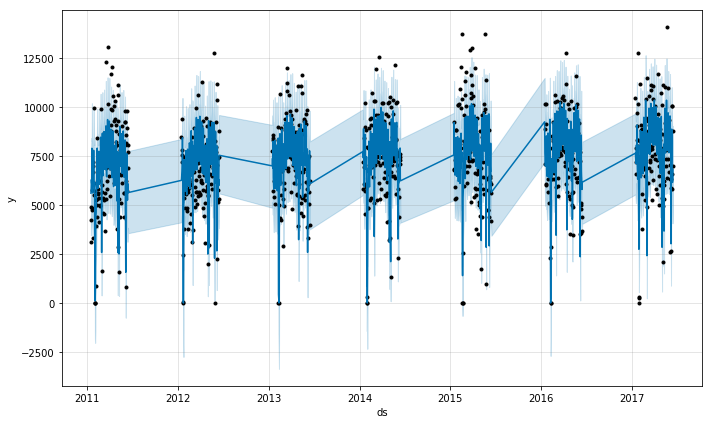

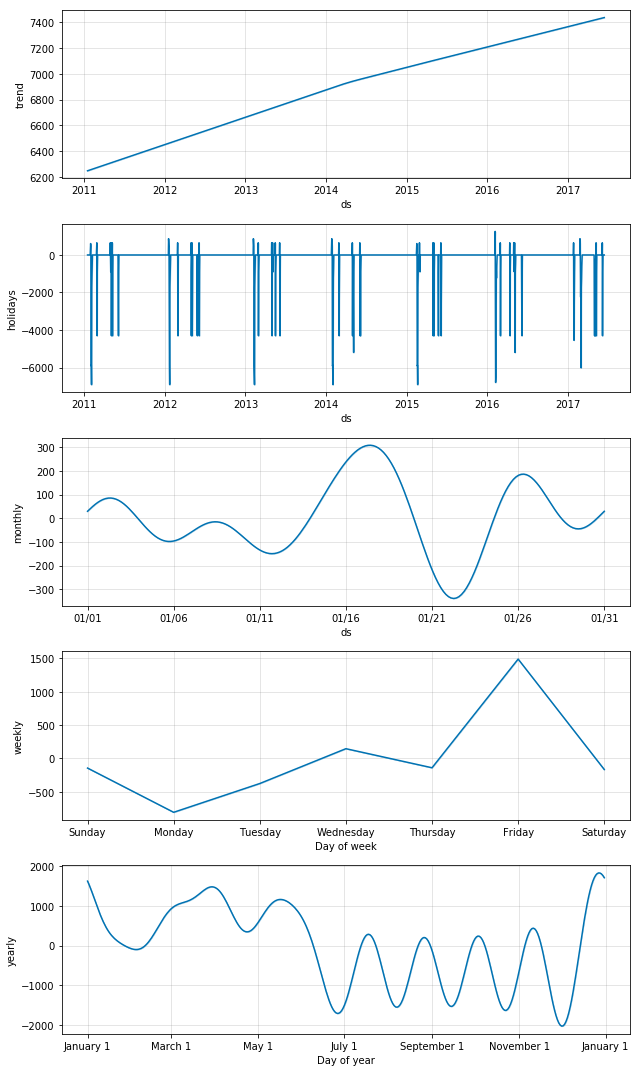

In [37]:
prpt_withobj.plot("obj_frozenset({0, 'boost', 'weekday'})")

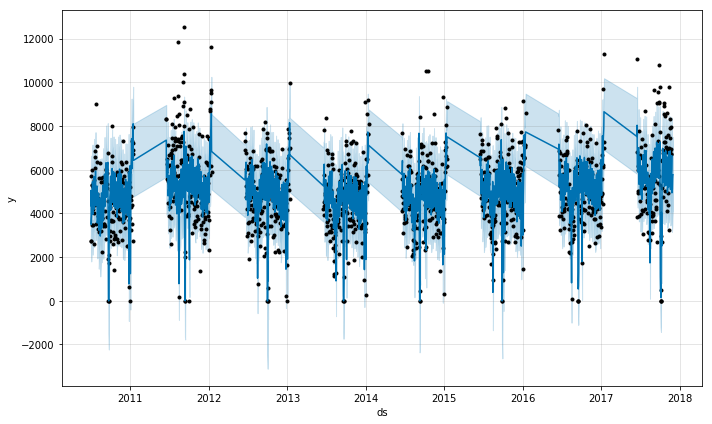

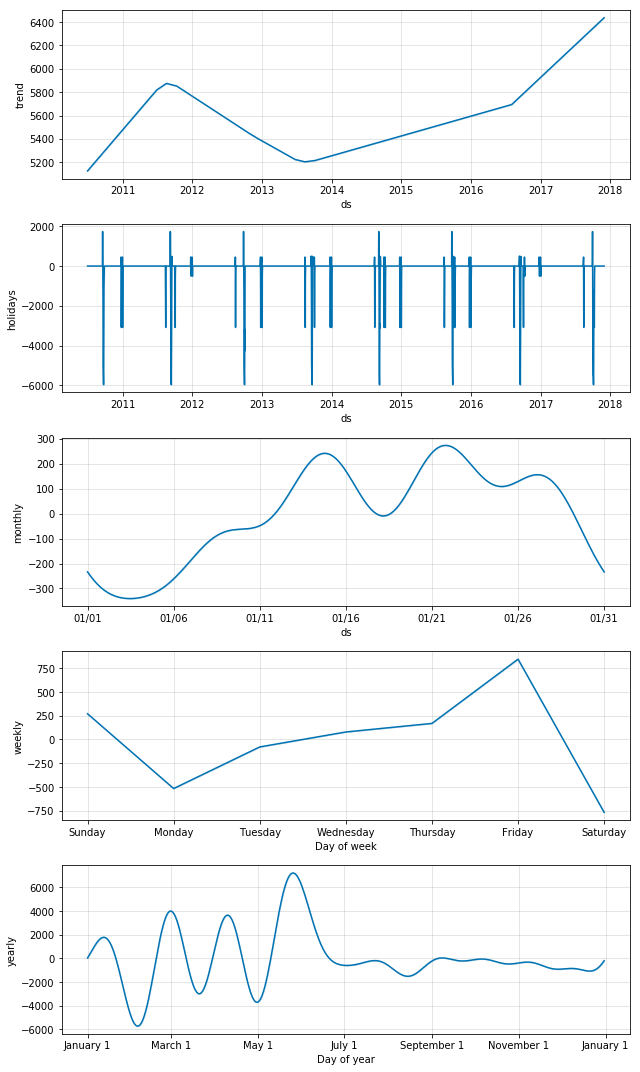

In [38]:
prpt_withobj.plot("obj_frozenset({0, 'ordinary', 'weekday'})")